In [1]:
import numpy as np
import pandas as pd
from scipy import io
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from nilearn import image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
import nibabel as nib
import math
import matplotlib.pyplot as plt
import cv2


# Test Data

In [2]:
img_name = './sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii'

test_img = []
for volume in image.iter_img(img_name):
    test_img.append(volume.dataobj)

test_img = np.array(test_img)
test_img.shape

(184, 64, 64, 30)

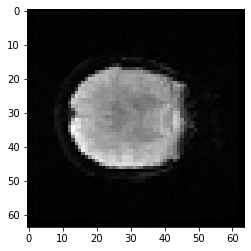

In [3]:
plt.imshow(test_img[1,:,:,15],cmap='gray')

In [4]:
# Load in segmented data generated from SPM12
mask_name = './sub-01/ses-test/func/c6msub-01_ses-test_task-fingerfootlips_bold.nii'

In [5]:
mask_img = nib.load(mask_name)
mask_img.shape

(64, 64, 30)

In [6]:
thresh,test_mask = cv2.threshold(mask_img.get_fdata(),0.9,1,cv2.THRESH_BINARY_INV)

(64, 64, 30)


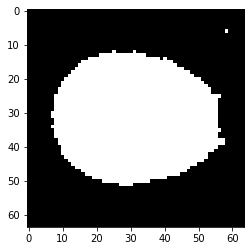

In [7]:
print(test_mask.shape)
plt.imshow(test_mask[:,:,15],cmap='gray')

## Image Masking

In [8]:
masked_img=[]
for i in range(184):
    ar3=[]
    for j in range(64):
        ar2=[]
        for k in range(64):
            ar1=[]
            for l in range(30):
                ar1.append(test_img[i][j][k][l]*test_mask[j][k][l])
            ar2.append(ar1)
        ar3.append(ar2)
    masked_img.append(ar3)

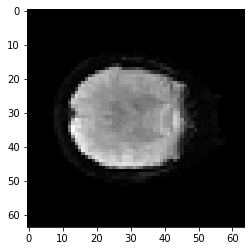

In [9]:
# Feature Extraction
masked_img = np.array(masked_img)
plt.imshow(masked_img[1,:,:,15],cmap='gray')


In [10]:
print(masked_img.shape)
# Reshape the masked images
masked_img = masked_img.reshape(184,-1)


(184, 64, 64, 30)


In [11]:
masked_img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
# Shape of masked images after transformation
masked_img.shape

(184, 122880)

In [22]:
# Reduce dimensions through PCA
pca = PCA(n_components=100)
pca_train = pca.fit_transform(masked_img)

In [14]:
pca_train.shape

(184, 100)

In [15]:
# Load labels
labels = io.loadmat('label.mat')
labels = labels['label'].flatten()
labels

array([1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3,
       1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 4, 4,
       4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1,
       1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4,
       4, 4, 1, 1, 1, 1, 1, 1], dtype=uint8)

In [42]:
# Fit SVM model
svc = SVC(kernel='linear', gamma='auto',random_state=43)

## Implement PCA + SVM through K-fold CV

In [43]:
# Implement K-fold Cross Validation with the best parameters
# Mean validation accuracy shown below
svm_scores = np.mean(cross_val_score(svc, pca_train, labels,cv=18))
print("The best average validation accuracy for svm model is: {}".format(svm_scores))

The best average validation accuracy for svm model is: 0.8611111111111112


In [61]:
# Use GridSearch for hyper-parameter tuning
svm = SVC()
hyperparams = {'kernel':['linear','poly','rbf','sigmoid'],
               'gamma' : [math.pow(2,i) for i in range(-10,5,2)],
               'C' : [math.pow(2,i) for i in range(-10,5,2)],
              }

cross_validation = StratifiedKFold(n_splits = 18)
grid_search = GridSearchCV(svm,param_grid = hyperparams,cv = cross_validation)

grid_search.fit(pca_train, labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

print(grid_search.best_estimator_)

Best score: 0.8611111111111112
Best parameters: {'C': 0.0009765625, 'gamma': 0.0009765625, 'kernel': 'linear'}
SVC(C=0.0009765625, gamma=0.0009765625, kernel='linear', random_state=999)


## Implement K-fold SVM method only

In [41]:
# Fit SVM model using masked image data (not reduced by PCA)
score2 = np.mean(cross_val_score(svc, masked_img, labels, cv=18))
print("The best average validation accuracy for svm model is: {}".format(score2))

The best average validation accuracy for svm model is: 0.8181818181818182


In [ ]:
# Parameter tuning 

#grid_search = GridSearchCV(svm,param_grid = hyperparams,cv = cross_validation)

#grid_search.fit(masked_img, labels)
#print('Best score: {}'.format(grid_search.best_score_))
#print('Best parameters: {}'.format(grid_search.best_params_))

#print(grid_search.best_estimator_)

# Re-test Data

In [169]:
retest_img_name = './sub-01/ses-retest/func/sub-01_ses-retest_task-fingerfootlips_bold.nii'

In [170]:
retest_img = []
for volume in image.iter_img(retest_img_name):
    retest_img.append(volume.dataobj)

In [171]:
retest_img = np.array(retest_img)
retest_img.shape

(184, 64, 64, 30)

In [172]:
# Load in segmented retest data generated from SPM12
retest_mask_name = './sub-01/ses-retest/func/c6sub-01_ses-retest_task-fingerfootlips_bold.nii'

In [173]:
retest_mask_img = nib.load(retest_mask_name)
retest_mask_img.shape

(64, 64, 30)

In [174]:
thresh,retest_mask = cv2.threshold(retest_mask_img.get_fdata(),0.9,1,cv2.THRESH_BINARY_INV)

(64, 64, 30)


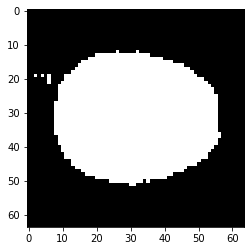

In [175]:
print(retest_mask.shape)
plt.imshow(retest_mask[:,:,15],cmap='gray')

## Retest Image Data Masking

In [176]:
retest_masked_img=[]
for i in range(184):
    ar3=[]
    for j in range(64):
        ar2=[]
        for k in range(64):
            ar1=[]
            for l in range(30):
                ar1.append(retest_img[i][j][k][l]*retest_mask[j][k][l])
            ar2.append(ar1)
        ar3.append(ar2)
    retest_masked_img.append(ar3)

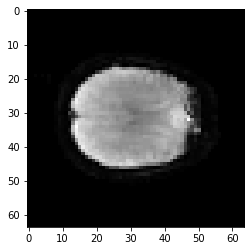

In [177]:
# Feature Extraction
retest_masked_img = np.array(retest_masked_img)
plt.imshow(retest_masked_img[1,:,:,15],cmap='gray')


In [178]:
print(retest_masked_img.shape)
# Reshape the retest masked images
retest_masked_img = retest_masked_img.reshape(184,-1)

(184, 64, 64, 30)


In [179]:
retest_masked_img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [180]:
# Shape of masked images after transformation
retest_masked_img.shape

(184, 122880)

In [185]:
# Reduce dimensions through PCA
retest_pca = PCA(n_components=90)
retest_pca_train = retest_pca.fit_transform(retest_masked_img)

In [186]:
retest_pca_train.shape

(184, 90)

In [187]:
# Create a SVM object 
retest_svc = SVC(kernel='linear', gamma='auto',random_state=43)

## Implement SVM + PCA with K-fold CV on Retest data

In [199]:
# Implement K-fold Cross Validation with the best parameters
# Mean validation accuracy shown below
retest_svm_scores = np.mean(cross_val_score(retest_svc, retest_pca_train, labels, cv=24))
print("The best average validation accuracy for svm model is: {}".format(retest_svm_scores))

The best average validation accuracy for svm model is: 0.8238888888888889


In [200]:
# Use Grid-search for hyper-parameter tuning
svm = SVC(random_state=43)
hyperparams = {'kernel':['linear','poly','rbf','sigmoid'],
               'gamma' : [math.pow(2,i) for i in range(-10,5,2)],
               'C' : [math.pow(2,i) for i in range(-10,5,2)],
              }

cross_validation = StratifiedKFold(n_splits = 24)
grid_search = GridSearchCV(svm,param_grid = hyperparams,cv = cross_validation)

grid_search.fit(retest_pca_train, labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

print(grid_search.best_estimator_)

Best score: 0.8430059523809524
Best parameters: {'C': 0.0009765625, 'gamma': 0.0009765625, 'kernel': 'linear'}
SVC(C=0.0009765625, gamma=0.0009765625, kernel='linear', random_state=43)


## Implement K-fold SVM Method only on Retest Data

In [201]:
retest_svm_scores2 = np.mean(cross_val_score(retest_svc, retest_masked_img, labels, cv=24))
print("The best average validation accuracy for svm model is: {}".format(retest_svm_scores2))

The best average validation accuracy for svm model is: 0.7976190476190476


In [ ]:
# Parameter tuning not included as it takes too long to run

#grid_search.fit(retest_masked_img, labels)
#print('Best score: {}'.format(grid_search.best_score_))
#print('Best parameters: {}'.format(grid_search.best_params_))

#print(grid_search.best_estimator_)